In [101]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from UtilityGraph import *
from Defence import *
from Corruption import *
from UtilityMLP import *
from itertools import cycle
import random
import copy
import seaborn as sns
from Test import *
import math

In [102]:
Seed = 2001  # for reproducibility
random.seed(Seed)
np.random.seed(Seed) 
torch.manual_seed(Seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(Seed)
    torch.cuda.manual_seed_all(Seed)


In [103]:
# Graph
required_probability=0.9999
num_nodes, G,A,pos,r_c=build_random_graph(50,required_probability,fix_num_nodes=True)
print("num_nodes:",num_nodes)

percentageCorrupt = 0   #Percentage of corrupt clients
corrupt = True              #If True, corrupt clients are included
CorruptClients = CorruptGeneration(percentageCorrupt, corrupt, num_nodes) #Selection of Corrupt Clients
CorruptClients = np.array(CorruptClients, dtype=int)



var = 30                  # Standard deviation for Gaussian noise
mean = 2000                    # Mean for Gaussian noise
Target = np.random.randint(1, num_nodes) # Target client for copycat attack
scale = 1
typeAttack = 1              # 0: No attack, 1: Gaussian noise, 2: Copycat attack, 3: Gaussian addative noise attack, 4: LIE attack

# Data
Data = np.zeros([num_nodes,1])
RealMean = 25
RealVar = 5
for i in range(num_nodes):
    Data[i] = np.random.normal(RealMean, np.sqrt(RealVar))

Control = Data.copy()



num_nodes: 50
IteNumber of Corrupt nodesration 0, Corrupt nodes: []


In [104]:
def normpdf(x, mn, var):
    denom = (2 * np.pi * var)**0.5 
    num = np.exp(-((x - mn)**2) / (2 * var + 1e-6)) 
    return num / (denom + 1e-6)

In [105]:
# Define the normal probability density function
def shownormpdf(mn, var):
    # Step 2: Create x values (input range)
    x = np.linspace(-10, 20, 500)  # Adjust the range to better visualize the Gaussian

    # Step 3: Compute y values (apply the function)
    y = normpdf(x,mn,var)

    # Step 4: Plot the function
    plt.plot(x, y, label='Normal PDF (mean={mn}, variance={var})'.format(mn=mn, var=var))

    # Step 5: Customize the plot
    plt.title("Plot of Normal Probability Density Function")  # Add title
    plt.xlabel("x")  # Label x-axis
    plt.ylabel("f(x)")  # Label y-axis
    plt.axhline(0, color='black', linewidth=0.5)  # Add x-axis line
    plt.axvline(0, color='black', linewidth=0.5)  # Add y-axis line
    plt.grid(True)  # Add grid
    plt.legend()

    # Step 6: Show the plot
    plt.show()
    return 0


In [106]:
def main():
    calc_mean = 0
    max_iters=1000000             #PDMM max iterations (not transmissions)
    averaging = 1/2           #Averaging alpha PDMM
    tolerance=-1                #PDMM tolerance
    c=1                       #PDMM c
    
    avg_temp = np.mean(Data)
    for i in range(num_nodes):
        if CorruptClients[i] == 1:
                Data[i] = np.random.normal(mean,  np.sqrt(var))

    print(avg_temp)
    Error = []
    Error_A = []
    Error, Transmission,calc_mean, dual_PDMM = PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging)
    Error_A, Transmission,calc_mean, dual_ADMM = ADMM(Data, G, avg_temp, tolerance, c, max_iters,Control)
    # print(calc_mean)

    plt.figure(figsize=(10, 4))

    # Plot  error
    plt.plot(range(len(Error)), Error, label='PDMM Convergence')
    plt.plot(range(len(Error_A)), Error_A, label='ADMM Convergence')
    plt.yscale('log')
    plt.title('Error Convergence Over Iteration Rounds')
    plt.xlabel('Iteration Round')
    plt.ylabel('Norm Error')
    plt.legend()

    # Optimize layout and display the plot
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.heatmap(dual_ADMM - dual_PDMM, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    plt.title('PDMM z Heatmap over Nodes Rounds')
    plt.xlabel('Nodes')
    plt.ylabel('Nodes')
    plt.tight_layout()
    plt.show()
    

In [107]:
def PDMM(Data, G, avg_temp, tolerance, c, max_iters,Control,averaging):
    # Create the histogram
    plt.figure(figsize=(6,4))
    plt.hist(Control, bins=20, edgecolor='black', alpha=0.7)
    plt.title("Distribution of data before corrupt clients")
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

    num_nodes = G.number_of_nodes()
    x=np.zeros([num_nodes,1])
    converged = False
    Error = np.array([])

    #initialise A_ij
    A_ij=calc_incidence_nested(G)
    #initialise z_ij and y_ij
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))
    temp_z = np.zeros((num_nodes, num_nodes))
    dual = np.zeros((num_nodes, num_nodes))
    test = np.zeros((num_nodes, num_nodes))

    count=0
    node_list = list(range(num_nodes))


    while not converged and count < max_iters:
        if count == 0:
            plt.figure(figsize=(10, 6))
            sns.heatmap(z, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
            plt.title('PDMM z Heatmap over Nodes Rounds')
            plt.xlabel('Nodes')
            plt.ylabel('Nodes')
            plt.tight_layout()
            plt.show()

        #update x_i and y_ij
        i = np.random.randint(0, num_nodes)

        if count == 0:
            print(i)

        #update x_i
        x[i]=Data[i]
        for j in G.neighbors(i):
            x[i]=x[i]-A_ij[i][j]*z[i][j]
        x[i]=x[i]/(1+c*G.degree(i))
        # print(f"x[{i}]: {x[i]}")
        #update y_ij
        for j in G.neighbors(i):
            temp_z[j][i] = y[i][j]
            y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])
        # print(f"y[{i}]: {y[i]}")


        mask = np.ones(len(x), dtype=bool)
        mask[CorruptClients] = False 
        diff = (x - avg_temp)[mask]
        Error = np.append(Error, np.linalg.norm(diff))
        # count = count + 1
        if np.linalg.norm(diff)< tolerance:
            print(f'Iteration {count}, Norm of difference: {Error:.8f}')
            # converged = True

        for j in G.neighbors(i):
            dual[j][i] = (y[j][i] + temp_z[j][i])/2 
            test[j][i] = (dual[j][i] - temp_z[j][i])/(c * A_ij[i][j] * -1)
            count = count + 1

        for j in G.neighbors(i):    
            z[i][j] = averaging * y[j][i] + (1 - averaging) * z[i][j]

                
        dual_values = []
        for i in G.nodes():
            for j in G.neighbors(i):
                # Append the dual value for the edge (i, j)
                dual_values.append(dual[j][i])
        
    # plt.figure(figsize=(10, 6))
    # sns.heatmap(dual, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    # plt.title('PDMM y Heatmap over Nodes Rounds')
    # plt.xlabel('Nodes')
    # plt.ylabel('Nodes')
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(10, 6))
    # sns.heatmap(y, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    # plt.title('PDMM y Heatmap over Nodes Rounds')
    # plt.xlabel('Nodes')
    # plt.ylabel('Nodes')
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(10, 6))
    # sns.heatmap(z, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    # plt.title('PDMM z Heatmap over Nodes Rounds')
    # plt.xlabel('Nodes')
    # plt.ylabel('Nodes')
    # plt.tight_layout()
    # plt.show()
    
    print(f"x = {x}")
    return Error,count, x, dual
    # return Error,count, np.mean(x)

In [108]:
def ADMM(Data, G, avg_temp, tolerance, rho, max_iters,Control):
    # Create the histogram
    plt.figure(figsize=(6,4))
    plt.hist(Control, bins=20, edgecolor='black', alpha=0.7)
    plt.title("Distribution of data")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

    num_nodes = G.number_of_nodes()
    x=np.zeros([num_nodes,1])
    converged = False
    Error = np.array([])
    
    #initialise z_ij and y_ij
    z = np.zeros((num_nodes, num_nodes))
    y = np.zeros((num_nodes, num_nodes))


    count=0
    while not converged and count < max_iters:
        node_list = list(range(num_nodes))

        i = np.random.randint(0, num_nodes)
        # print(f"This is node {i}")

        if count == 0:
            print(i)
        neighbors_i = list(G.neighbors(i))
        
        # Randomly pick one neighbor j
        j = random.choice(neighbors_i)
        
        # Update x[i]
        # x[i] = (Data[i] + sum_over_j (rho*z[i][j] - y[i][j])) / (1 + rho*deg(i))
        numerator_i = Data[i]
        for nbr in neighbors_i:
            numerator_i = numerator_i + rho * z[i][nbr] - y[i][nbr]
        x[i] = numerator_i / (1 + rho * G.degree(i))


        # Update neighbors of j to update x[j]
        neighbors_j = list(G.neighbors(j))
        numerator_j = Data[j]
        for nbr in neighbors_j:
            numerator_j = numerator_j + rho * z[j][nbr] - y[j][nbr]
        x[j] = numerator_j / (1 + rho * G.degree(j))



        z[i][j] = 0.5 * (x[i] + x[j])
        z[j][i] = z[i][j]
        count = count + 2


        # Update y[i][j] and y[j][i]
        y[i][j] = y[i][j] + rho * (x[i] - z[i][j])
        y[j][i] = y[j][i] + rho * (x[j] - z[j][i])
        count = count + 2


        # Compute error and check convergence
        diff = x - avg_temp
        norm_diff = np.linalg.norm(diff)
        Error = np.append(Error, norm_diff)
        if norm_diff < tolerance:
            print(f'Iteration {count}, Norm of difference: {norm_diff:.8f}')
            # converged = True

        all_values = y.flatten()
        non_zero_values = all_values[all_values != 0]


    # plt.figure(figsize=(10, 6))
    # sns.heatmap(y, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    # plt.title('PDMM y Heatmap over Nodes Rounds')
    # plt.xlabel('Nodes')
    # plt.ylabel('Nodes')
    # plt.tight_layout()
    # plt.show()

    # plt.figure(figsize=(10, 6))
    # sns.heatmap(z, annot=False, cmap="viridis", cbar=True)  # Adjust 'annot' or 'cmap' as needed
    # plt.title('PDMM z Heatmap over Nodes Rounds')
    # plt.xlabel('Nodes')
    # plt.ylabel('Nodes')
    # plt.tight_layout()
    # plt.show()

    # all_values = y.flatten()            # Plot the histogram
    # non_zero_values = all_values[all_values != 0]
    # plt.hist(non_zero_values, bins=100, edgecolor='black', alpha=0.7, density=True, label="Histogram")
    # plt.title("Distribution")
    # plt.xlabel("Value")
    # plt.ylabel("Density")
    # plt.tight_layout()
    # plt.show()

    print(f"x = {x}")
    return Error,count, x, y

24.952241987436842


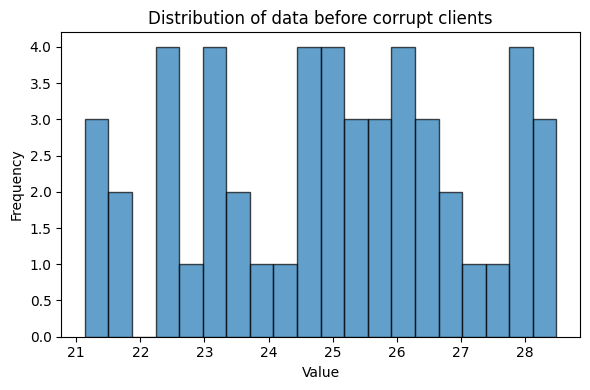

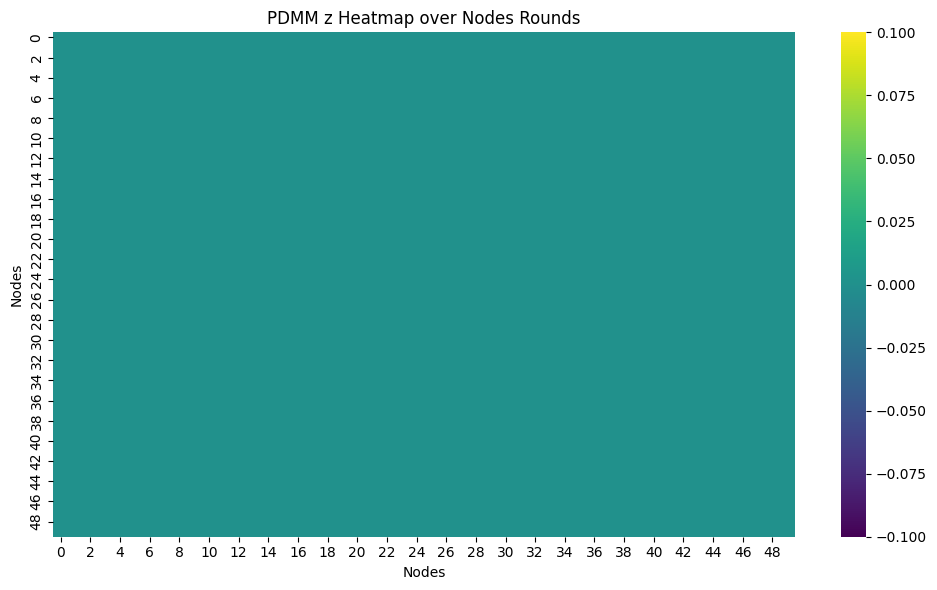

2


C:\Users\za_re\AppData\Local\Temp\ipykernel_11136\2255243806.py:54: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i][j]=z[i][j]+2*c*(x[i]*A_ij[i][j])


x = [[24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]
 [24.95224199]]


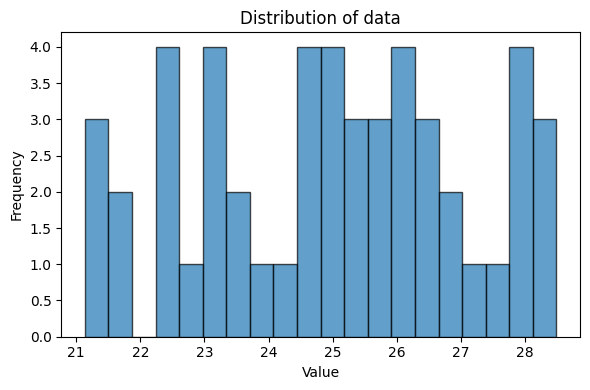

26


C:\Users\za_re\AppData\Local\Temp\ipykernel_11136\2042499319.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  z[i][j] = 0.5 * (x[i] + x[j])
C:\Users\za_re\AppData\Local\Temp\ipykernel_11136\2042499319.py:59: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[i][j] = y[i][j] + rho * (x[i] - z[i][j])
C:\Users\za_re\AppData\Local\Temp\ipykernel_11136\2042499319.py:60: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y[j][i] = y[j][i] + rho * (x[j] - z[j][i])


KeyboardInterrupt: 

In [109]:
if __name__ == '__main__':
    main()